In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cmocean
import pickle
import os
from scipy import signal
from scipy.optimize import curve_fit
from salishsea_tools import timeseries_tools, utilities, tidetools, viz_tools, geo_tools, places, nc_tools
from matplotlib import gridspec
from datetime import datetime, timedelta
from copy import deepcopy

%matplotlib inline

### Local functions

In [4]:
def reshape_to_grid(data, gridx, gridy, shape, xslice=None, yslice=None, subfac=None):
    """
    """
    
    gridded = np.zeros(shape)
    for y, x, val in zip(gridy, gridx, data):
        gridded[..., y, x] = val
    if xslice is not None:
        gridded = gridded[..., slice(*yslice), :]
    if yslice is not None:
        gridded = gridded[..., slice(*xslice)]
    if subfac is not None:
        gridded = gridded[..., ::subfac, ::subfac]

    return gridded

In [22]:
def calc_EOF(
    timeseries, gridx, gridy, shape,
    xslice=None, yslice=None, subfac=None,
    timecut=None, spacecut=None, calc_varimax=False,
):
    """
    """
    
    EOF = {}
    
    # Detrend timeseries (Butterworth filter)
    Z = deepcopy(timeseries)
    if timecut is not None:
        for i, col in enumerate(Z.T):  # --- Temporal trend
            Z[:, i] = col - signal.filtfilt(*signal.butter(2, timecut), col)
    if spacecut is not None:
        for i, row in enumerate(Z):  # ----- Spatial trend
            Z[i, :] = row - signal.filtfilt(*signal.butter(2, spacecut), row)
    
    # Calculate EOFs
    A_prime, sqrtL, E_T = np.linalg.svd(Z, full_matrices=False)
    EOF['A'] = A_prime.dot(np.diag(sqrtL))
    EOF['var'] = (EOF['A']**2).sum(axis=0) / (EOF['A']**2).sum()
    
    # Reshape modes
    EOF['E'] = []
    for mode in range(5):
        EOF['E'].append(reshape_to_grid(
            E_T.T[:, mode], gridx, gridy, shape,
            xslice=xslice, yslice=yslice, subfac=subfac,
        ))
    
    # Varimax rotation
    if calc_varimax:
        R = varimax(EOF['A'])
        EOF['B'] = EOF['A'].dot(R)
        EOF['Rvar'] = (EOF['B']**2).sum(axis=0) / (EOF['B']**2).sum()
        
        # Reshape modes
        EOF['U'] = []
        for mode in range(5):
            EOF['U'].append(reshape_to_grid(
                E_T.T.dot(R)[:, mode], gridx, gridy, shape,
                xslice=xslice, yslice=yslice, subfac=subfac,
            ))
    
    return EOF

In [6]:
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    """From Wikipedia Varimax talk page
    https://en.wikipedia.org/wiki/Talk:Varimax_rotation
    """
    
    p, k = Phi.shape
    R = np.eye(k)
    d = 0
    for i in range(q):
        d_old = d
        Lambda = Phi.dot(R)
        u, s, vh = np.linalg.svd(Phi.T.dot(
            np.asarray(Lambda)**3 - (gamma/p) *
            Lambda.dot(np.diag(np.diag(Lambda.T.dot(Lambda))))
        ))
        R = u.dot(vh)
        d = sum(s)
        if d_old != 0 and d/d_old < 1 + tol: break
    return R

### Prep slice params and indices

In [7]:
# Domain slice parameters
timerange = ['2016 Jan 1 00:00', '2016 Dec 31 23:59']
xslice, yslice = [100, 320], [380, 800]
zslice = 0
subfac = 5

# Create x and y indices
gridx, gridy = np.meshgrid(range(*xslice), range(*yslice))
gridx, gridy = gridx[::subfac, ::subfac], gridy[::subfac, ::subfac]

# Number of water points
nwater = np.prod(gridx.shape)

# Create reshaped tmask
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
tmask = mask.tmask.isel(t=0, z=zslice)
tmask[720:, :135] = 0  # mask out Discovery Passage nutrient plume
tmask = tmask.isel(y=slice(*yslice), x=slice(*xslice)).values.astype(bool)[::subfac, ::subfac].reshape(nwater)

# Reshape x and y indices
gridx = gridx.reshape(nwater)[tmask]
gridy = gridy.reshape(nwater)[tmask]

# Build time index
T = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')
time = T.time.sel(time=slice(*timerange)).values.astype('datetime64[s]').astype(datetime)

Load wind

In [8]:
# Load v wind
GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
v_wind = GEM.v_wind.sel(time=slice(*timerange)).isel(gridY=j, gridX=i)

### Extract nowcast results and reshape to timeseries
Predefine filenames, timeseries array, quantity, vertical method, and dump params

In [9]:
# Predefine filenames, timeseries array, quantity, vertical method, and dump params
filenames = timeseries_tools.make_filename_list(timerange, 'T', ftype='ptrc', model='hindcast')
qty = 'nitrate'
vmethod = 'slice'
fieldID = qty + timerange[0].split()[0] + vmethod + str(zslice)
dumpfile = os.path.join('/ocean/bmoorema/research/MEOPAR/analysis-ben/data', fieldID + '_dump')

**STOP!** This is the main extraction step and will take some time. Execute when ready ...

In [10]:
# Loop through filenames
timeseries = np.empty((0, tmask.sum()))
bar = utilities.statusbar(f'Loading {qty} ...')
for filename in bar(filenames):
    
    # Load field from results file
    data = xr.open_dataset(filename).isel(y=slice(*yslice), x=slice(*xslice))[qty]
    
    # Either (1) extract horizontal slice at z index
    if vmethod is 'slice':
        data_reshape = data.isel(deptht=zslice).values[:, ::subfac, ::subfac].reshape(data.shape[0], nwater)[:, tmask]
    
    # Or (2) find depths of maximum values
    elif vmethod is 'max':
        data_reshape = np.take(
            data.deptht.values, data.values[:, :, ::subfac, ::subfac].argmax(axis=1),
        ).reshape(data.shape[0], nwater)[:, tmask]
    
    # Concatenate array onto timeseries array
    timeseries = np.concatenate((timeseries, data_reshape), axis=0)

# Dump timeseries results to pickle file
with open(dumpfile, 'wb') as output_file:
    pickle.dump({fieldID: timeseries}, output_file)

Loading nitrate ... 100% (366 of 366) |####################################|Time: 0:23:51


### Calculate EOFs

In [23]:
# Loop through variables
EOF = {}
for qty in ['vosaline', 'nitrate']:

    # Load from pickle
    filename = f'/ocean/bmoorema/research/MEOPAR/analysis-ben/data/{qty}2016slice0_dump'
    with open(filename, 'rb') as fid:
        timeseries = pickle.load(fid)[qty + 'slice0']

    # Lowpass filter params
    timecut = 0.001
    spacecut = 0.05

    # Calculate EOFs
    EOF[qty] = calc_EOF(
        timeseries, gridx, gridy, mask.nav_lon.shape,
        xslice=xslice, yslice=yslice, subfac=subfac,
        timecut=timecut, spacecut=spacecut, calc_varimax=True,
    )

### Plot Hindcast PCs

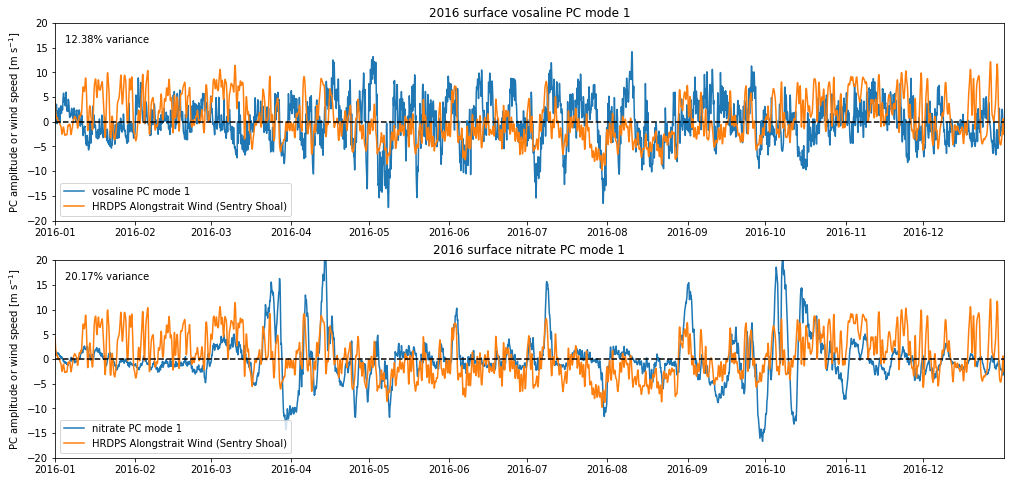

In [62]:
# Make figure
mode = 0
fig, axs = plt.subplots(2, 1, figsize=(17, 8))

for ax, qty in zip(axs, ['vosaline', 'nitrate']):

    ax.plot(time, -EOF[qty]['A'][:, mode]/5, label=f'{qty} PC mode {mode+1}')
    ax.plot(v_wind.time, signal.filtfilt(*signal.butter(2, 0.1), v_wind), label='HRDPS Alongstrait Wind (Sentry Shoal)')
    ax.plot([time[0], time[-1]], [0, 0], 'k--')
    ax.set_xlim(timerange)
    ax.set_ylim([-20, 20])
    ax.set_ylabel('PC amplitude or wind speed [m s$^{-1}$]')
    PercentVar = EOF[qty]['var'][mode]*100
    ax.text(0.01, 0.9, f'{PercentVar:.2f}% variance', transform=ax.transAxes)
    ax.set_title(f'2016 surface {qty} PC mode {mode+1}')
    ax.legend(loc=3)

plt.show()

### Plot Hindcast EOFs

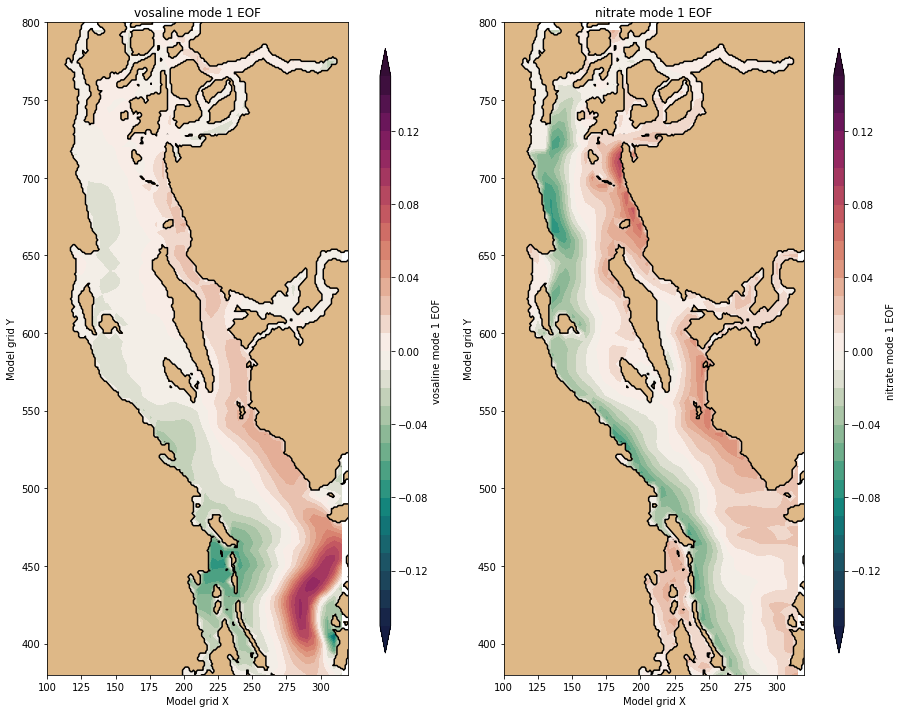

In [72]:
# Make figure
mode = 0
fig, axs = plt.subplots(1, 2, figsize=(15, 12))

for ax, qty, cpos in zip(axs, ['vosaline', 'nitrate'], [0.47, 0.89]):
    
    # Formatting
    ax.set_xlim(xslice)
    ax.set_ylim(yslice)
    ax.set_xlabel('Model grid X')
    ax.set_ylabel('Model grid Y')
    ax.set_title(f'{qty} mode {mode+1} EOF')
    viz_tools.set_aspect(ax)

    # Plot EOF
    c = ax.contourf(
        range(*xslice, 5), range(*yslice, 5), EOF[qty]['E'][mode], 
        levels=np.arange(-0.15, 0.151, 0.01),
        cmap=cmocean.cm.curl, extend='both',
    )

    # Colorbar
    cax = fig.add_axes([cpos, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label=f'{qty} mode {mode+1} EOF')
    
    # Plot landmask
    ax.contourf(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='k')

# Output
plt.show()

### Passive Tracer EOFs

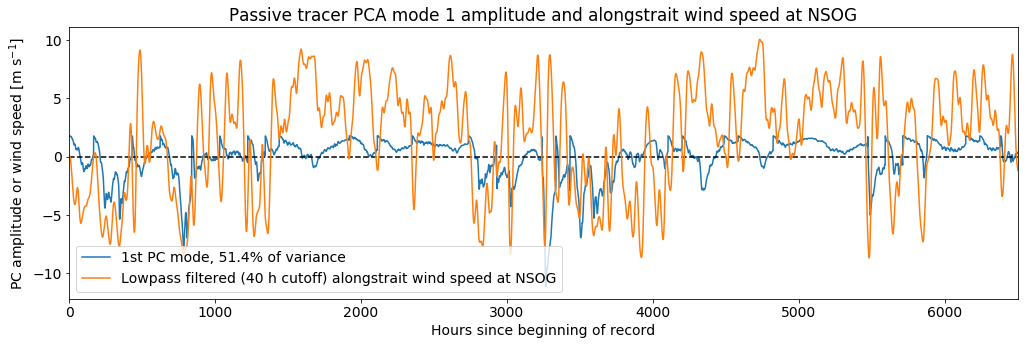

In [286]:
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(A[:, 0], label=f'1st PC mode, {100*PercentVar[0]:.1f}% of variance')
ax.plot([0, 6500], [0, 0], 'k--')
ax.plot(signal.filtfilt(*signal.butter(2, 0.05), -V), label='Lowpass filtered (40 h cutoff) alongstrait wind speed at NSOG')
ax.set_xlim([0, 6500])
ax.set_ylabel('PC amplitude or wind speed [m s$^{-1}$]')
ax.set_xlabel('Hours since beginning of record')
ax.set_title('Passive tracer PCA mode 1 amplitude and alongstrait wind speed at NSOG')
ax.legend(loc=3)
fig.savefig('/home/bmoorema/Desktop/PC_wind.pdf', dpi=300, bbox_inches='tight')

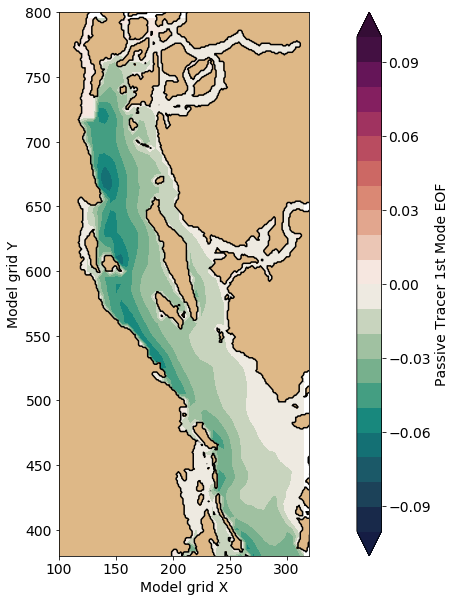

In [278]:
# Plot Rotated
EOF = []
for mode in range(2):
    EOF.append(np.zeros(mask.nav_lon.shape))
    for y, x, val in zip(gridy, gridx, E_T[mode, :]):
        EOF[mode][y, x] = val
    EOF[mode] = EOF[mode][slice(*yslice), slice(*xslice)][::subfac, ::subfac]
fig, ax = plt.subplots(1, 1, figsize=(17, 10))
c = ax.contourf(range(*xslice, 5), range(*yslice, 5), EOF[0], levels=np.arange(-0.1, 0.101, 0.01), cmap=cmocean.cm.curl, extend='both')
ax.contourf(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='burlywood')
ax.contour(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='k')
ax.set_xlim(xslice)
ax.set_ylim(yslice)
ax.set_xlabel('Model grid X')
ax.set_ylabel('Model grid Y')
viz_tools.set_aspect(ax)
fig.colorbar(c, label='Passive Tracer 1st Mode EOF')
plt.show()
fig.savefig('/home/bmoorema/Desktop/EOF.pdf', dpi=300, bbox_inches='tight')

In [99]:
filenames = [
    '/data/vdo/MEOPAR/completed-runs/stats-runs/21sep14/SalishSea_1h_20140921_20140927_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/15oct14/SalishSea_1h_20141015_20141025_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03dec14/SalishSea_1h_20141203_20141211_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/29jun15/SalishSea_1h_20150629_20150706_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/13jul15/SalishSea_1h_20150713_20150722_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/27aug15/SalishSea_1h_20150827_20150903_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/24jul16/SalishSea_1h_20160724_20160802_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/02aug16/SalishSea_1h_20160802_20160828_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03apr17/SalishSea_1h_20170403_20170407_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/10jun17/SalishSea_1h_20170610_20170616_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/23jul17/SalishSea_1h_20170723_20170728_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/12sep17/SalishSea_1h_20170912_20170916_ptrc_T.nc',
]

filenames_all = [
    '/data/vdo/MEOPAR/completed-runs/stats-runs/21sep14/SalishSea_1h_20140921_20140927_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/15oct14/SalishSea_1h_20141015_20141025_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/27nov14/SalishSea_1h_20141127_20141204_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03dec14/SalishSea_1h_20141203_20141211_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/23dec14/SalishSea_1h_20141223_20141230_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/16apr15/SalishSea_1h_20150416_20150423_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/25apr15/SalishSea_1h_20150425_20150429_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/30apr15/SalishSea_1h_20150430_20150503_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03jun15/SalishSea_1h_20150603_20150622_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/29jun15/SalishSea_1h_20150629_20150706_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/13jul15/SalishSea_1h_20150713_20150722_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/09aug15/SalishSea_1h_20150809_20150824_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/27aug15/SalishSea_1h_20150827_20150903_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/13nov15/SalishSea_1h_20151113_20151125_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/13dec15/SalishSea_1h_20151212_20151215_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/23dec15/SalishSea_1h_20151223_20151226_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/10jan16/SalishSea_1h_20160110_20160206_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/26mar16/SalishSea_1h_20160326_20160329_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03may16/SalishSea_1h_20160503_20160514_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/17may16/SalishSea_1h_20160517_20160520_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/24jul16/SalishSea_1h_20160724_20160802_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/02aug16/SalishSea_1h_20160802_20160828_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/29dec16/SalishSea_1h_20161229_20170102_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/03apr17/SalishSea_1h_20170403_20170407_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/10jun17/SalishSea_1h_20170610_20170616_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/19jun17/SalishSea_1h_20170619_20170629_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/08jul17/SalishSea_1h_20170708_20170711_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/23jul17/SalishSea_1h_20170723_20170728_ptrc_T.nc',
    '/data/vdo/MEOPAR/completed-runs/stats-runs/17dec17/SalishSea_1h_20171217_20171221_ptrc_T.nc',
]

In [104]:
bar = utilities.statusbar('Loading ...')
tracer = np.empty((0, tmask[0].sum()))
for filename in bar(filenames_all):
    trace = xr.open_dataset(filename).isel(deptht=0, y=slice(*yslice), x=slice(*xslice)).mytracer3
    tracer = np.concatenate((tracer, trace.values[:, ::subfac, ::subfac].reshape(trace.shape[0], nwater)[:, tmask[0]]), axis=0)
with open('/home/bmoorema/Desktop/tracer_backup', 'wb') as output_file:
    pickle.dump({'tracer': tracer}, output_file)

Loading ... 100% (29 of 29) |##############################################|Time: 0:21:50


In [106]:
# Calculate EOFs
Z = tracer - tracer.mean(axis=0)[np.newaxis, :]
A_prime, sqrtL, E_T = np.linalg.svd(Z, full_matrices=False)
A = A_prime.dot(np.diag(sqrtL))
R = varimax(A)
B = A.dot(R)
U = E_T.T.dot(R)
PercentVar = sqrtL**2/(sqrtL**2).sum()

In [335]:
Quadra = '/data/vdo/MEOPAR/completed-runs/candidates/quadra/jun15lake/SalishSea_1h_20150531_20150624_ptrc_T.nc'
Baynes = '/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15lake/SalishSea_1h_20150424_20150429_ptrc_T.nc'

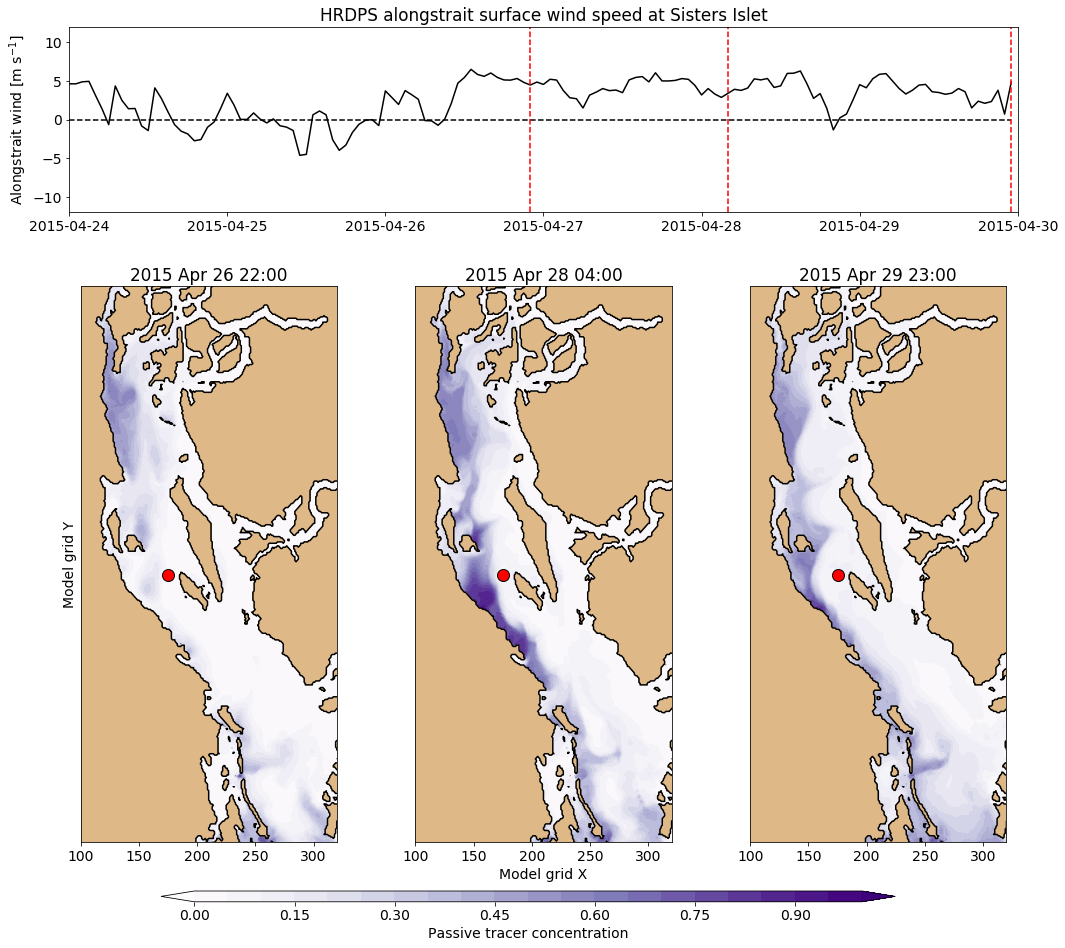

In [491]:
filename = Baynes
#time_index = [220, 280, 320]
time_index = [70, 100, 143]
#xlim = ['2015 Jun 4', '2015 Jun 17']
xlim = ['2015 Apr 24', '2015 Apr 30']
wind_station = 'Sisters Islet'

fig = plt.figure(figsize=(17, 15))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 3])
ax_top = fig.add_subplot(gs[0, :])
ax_bottom = [fig.add_subplot(gs[1, col]) for col in range(3)]
cax = fig.add_axes([0.2, 0.07, 0.6, 0.01])
ax_bottom[1].set_xlabel('Model grid X')
ax_bottom[0].set_ylabel('Model grid Y')

j, i = places.PLACES[wind_station]['GEM2.5 grid ji']
v_wind = GEM.sel(time=slice(*filename.split('_')[2:4])).isel(gridY=j, gridX=i).v_wind
ax_top.plot(v_wind.time, v_wind, 'k-')
ax_top.plot(v_wind.time, np.zeros(len(v_wind.time)), 'k--')
for t in time_index:
    time_i = nc_tools.xarraytime_to_datetime(v_wind.time.isel(time=t))
    ax_top.plot([time_i, time_i], [-12, 12], 'r--')
ax_top.set_xlim(xlim)
ax_top.set_ylim([-12, 12])
ax_top.set_ylabel('Alongstrait wind [m s$^{-1}$]')
ax_top.set_title(f'HRDPS alongstrait surface wind speed at {wind_station}')

Run = xr.open_dataset(filename).mytracer3.isel(deptht=0)
for ax, t in zip(ax_bottom, time_index):
    
    c = ax.contourf(Run.isel(time_counter=t), cmap='Purples', levels=np.arange(0, 1.01, 0.05), extend='both')
    ax.contourf(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='k')
    j, i = places.PLACES[wind_station]['NEMO grid ji']
    ax.plot(i, j, 'ro', markersize=12, markeredgecolor='k', linewidth=3)
    ax.set_xlim(xslice)
    ax.set_ylim(yslice)
    title = nc_tools.xarraytime_to_datetime(v_wind.isel(time=t).time).strftime('%Y %b %d %H:%M')
    ax.set_title(title)
    viz_tools.set_aspect(ax)
    if t != 220:
        ax.yaxis.set_ticks([])
        
fig.colorbar(c, cax=cax, orientation='horizontal', label='Passive tracer concentration')
plt.show()
fig.savefig('/home/bmoorema/Desktop/Baynes.pdf', dpi=300, bbox_inches='tight')